In [13]:
import torch
import pandas as pd
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
from torchinfo import summary
import numpy as np
import matplotlib.pyplot as plt

### Loading Data

In [14]:
training_data = datasets.mnist.FashionMNIST(root="data", train=True, download=True, transform=ToTensor())
test_data = datasets.mnist.FashionMNIST(root="data", train=False, download=True, transform=ToTensor())

In [15]:

print("Original size training data:",len(training_data))
print("Size test data:",len(test_data), "\n")
training_data, validation_data = torch.utils.data.random_split(training_data, [50000, 10000])

print("News size training data:",len(training_data))
print("Size validation data:",len(test_data))

Original size training data: 60000
Size test data: 10000 

News size training data: 50000
Size validation data: 10000


In [16]:
print(len(training_data),len(validation_data),len(test_data))

50000 10000 10000


### MLP


In [17]:
def mlp(units = [28*28,250,80,10]):
    seq = [torch.nn.Flatten()]
    for i in range(len(units)-2):
        seq.append(torch.nn.Linear(units[i],units[i+1]))
        seq.append(torch.nn.Sigmoid())
    seq.append(torch.nn.Linear(units[-2],units[-1]))
    return torch.nn.Sequential(*seq)

In [18]:
model = mlp()
from torchinfo import summary
summary(model, (1,28,28))

Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               --                        --
├─Flatten: 1-1                           [1, 784]                  --
├─Linear: 1-2                            [1, 250]                  196,250
├─Sigmoid: 1-3                           [1, 250]                  --
├─Linear: 1-4                            [1, 80]                   20,080
├─Sigmoid: 1-5                           [1, 80]                   --
├─Linear: 1-6                            [1, 10]                   810
Total params: 217,140
Trainable params: 217,140
Non-trainable params: 0
Total mult-adds (M): 0.22
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.87
Estimated Total Size (MB): 0.87

### Training

Implement the training / evaluation loop

Remember training / validation cost and accuracy per epoch. 

In [19]:
def train_eval(model, optimizer, _nepochs, training_loader, test_loader, scheduler=None, logs=True):
    cost_hist = []
    cost_hist_test = []
    acc_hist = []
    acc_hist_test = []

    cost_ce = torch.nn.CrossEntropyLoss()
        
    for epoch in range(_nepochs):
        model.train()
        size = len(training_loader.dataset)
        nbatches = len(training_loader)
        size_test = len(test_loader.dataset)
        nbatches_test = len(test_loader)
        cost, acc = 0.0, 0.0
        for batch, (X, Y) in enumerate(training_loader):
            pred = model(X)
            loss = cost_ce(pred, Y)
            cost += loss.item()
            acc += (pred.argmax(dim=1) == Y).type(torch.float).sum().item()

            # gradient, parameter update
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        if scheduler:
            scheduler.step()
        cost /= nbatches
        acc /= size
    
        model.eval()
        cost_test, acc_test = 0.0, 0.0        
        with torch.no_grad():
            for X, Y in test_loader:
                pred = model(X)
                cost_test += cost_ce(pred, Y).item()
                acc_test += (pred.argmax(dim=1) == Y).type(torch.float).sum().item()
        cost_test /= nbatches_test
        acc_test /= size_test
        if logs:
            print("Epoch %i: %f, %f, %f, %f"%(epoch, cost, acc, cost_test, acc_test))
        cost_hist.append(cost)
        cost_hist_test.append(cost_test)
        acc_hist.append(acc)
        acc_hist_test.append(acc_test)
    return cost_hist, cost_hist_test, acc_hist, acc_hist_test

In [20]:
class OptimizerParams:
    def __init__(self, name = "", lr=0.01, mr=0, nesterov=False, alpha = 0, centered: bool = False):
        self.name: str = name
        self.lr: float = lr
        self.mr: float = mr
        self.nesterov: bool = nesterov
        self.alpha: float = alpha
        self.centered: bool = centered

    def __str__(self):
        return f"{self.name} | lr: {self.lr}, mr: {self.mr}, nesterov: {self.nesterov}, alpha: {self.alpha}, centered: {self.centered}"

    def config_string(self):
        return f"lr: {self.lr}, mr: {self.mr}, nesterov: {self.nesterov}, alpha: {self.alpha}"

class SchedulerParams:
    def __init__(self, step_size=10, gamma=0.1):
        self.step_size: int = step_size
        self.gamma: float = gamma

    def __str__(self):
        return f"Step size: {self.step_size} | gamma: {self.gamma}"



class Config:
    def __init__(self,
                 create_model = None,
                 create_optimizer = None,
                 optimizer_params = OptimizerParams(),
                 epochs: list=None,
                 scheduler_params=None,
                 bs = 64,
                 ):
        if epochs is None:
            epochs = [1]

        self.model = None
        self.optimizer = None
        self.scheduler = None
        self.optimizer_params: OptimizerParams = optimizer_params

        self.create_model = create_model
        self.create_optimizer = create_optimizer

        self.epochs: list = epochs
        self.scheduler_params: SchedulerParams = scheduler_params
        self.bs = bs

        self.reset()
        self.build_scheduler()

    def reset(self):
        self.model = self.create_model()
        self.optimizer = self.create_optimizer(self.model, self.optimizer_params)

    def build_scheduler(self):
        self.scheduler = torch.optim.lr_scheduler.StepLR(self.optimizer, step_size=self.scheduler_params.step_size, gamma=self.scheduler_params.gamma) if self.scheduler_params is not None else None


class Result:
    def __init__(self, _config: Config):

        self.config: Config = _config
        self.models = []

        self.result_hist = pd.DataFrame(columns=['optimizer', 'optimizer_config', 'lr', 'mr', 'nesterov', 'alpha', 'num_epochs', 'batch_size', 'cost_train', 'cost_valid', 'acc_train', 'acc_valid'])
        self.cost_hists_train = []
        self.acc_hists_train = []
        self.cost_hists_valid = []
        self.acc_hists_valid = []


    def add_result(self, model, lr, num_epochs, cost_train_hist, acc_train_hist, cost_valid_hist, acc_valid_hist):
        max_acc = max(acc_valid_hist)
        max_index = acc_valid_hist.index(max_acc)
        _params = self.config.optimizer_params

        self.models.append(model)

        self.result_hist.loc[len(self.result_hist.index)] = [
            _params.name,
            _params.config_string(),
            _params.lr,
            _params.mr,
            _params.nesterov,
            _params.alpha,
            num_epochs,
            self.config.bs,
            cost_train_hist[max_index],
            cost_valid_hist[max_index],
            acc_train_hist[max_index],
            acc_valid_hist[max_index]
        ]
        self.result_hist.reset_index(drop=True)

        self.cost_hists_train.append((self.config.optimizer_params, num_epochs, cost_train_hist))
        self.acc_hists_train.append((lr, num_epochs,acc_train_hist))
        self.cost_hists_valid.append((lr, num_epochs, cost_valid_hist))
        self.acc_hists_valid.append((lr, num_epochs, acc_valid_hist))

    def get_max_acc_index(self):
        acc = self.result_hist['acc_valid']
        return acc.idxmax()

    def get_max_acc(self):
        acc = self.result_hist['acc_valid']
        return acc.max()

    def get_max_model(self):
        max_index = self.get_max_acc_index()
        return self.models[max_index]

    def get_max_histories(self):
        max_index = self.get_max_acc_index()
        return self.config, self.cost_hists_train[max_index], self.cost_hists_valid[max_index], self.acc_hists_train[max_index], self.acc_hists_valid[max_index]

    def get_max_accuracy_histories(self):
        max_index = self.get_max_acc_index()
        return self.config, self.acc_hists_train[max_index], self.acc_hists_valid[max_index]

    def get_max_cost_histories(self):
        max_index = self.get_max_acc_index()
        return self.config, self.cost_hists_train[max_index], self.cost_hists_valid[max_index]

    def get_max_hist_entry(self):
        max_index = self.get_max_acc_index()
        return [
            self.config.optimizer_params.name,
            self.result_hist.iloc[max_index]['optimizer_config'],
            self.result_hist.iloc[max_index]['lr'],
            self.result_hist.iloc[max_index]['mr'],
            self.result_hist.iloc[max_index]['nesterov'],
            self.result_hist.iloc[max_index]['alpha'],
            self.result_hist.iloc[max_index]['num_epochs'],
            self.result_hist.iloc[max_index]['batch_size'],
            self.result_hist.iloc[max_index]['acc_train'],
            self.result_hist.iloc[max_index]['acc_valid'],
        ]

### Analyse Different Optimisers with different Settings 

Use the code above to explore different settings for the different optimizers. Use batchsize 64.

1. SGD: Revisit plain SGD (without momentum) and try different learning rates (lr). Create suitable comparison plots (learning curves with the train and validate cost and accuracy) for (~3) different learning rates. Describe in words what you see. What is a reasonable number of epochs (nepochs)? What is your recommended best choice (lr, nepochs) for the given problem?

2. Momentum: Play with different settings when using momentum: learning rate, momentum parameter, Nesterov flag. Start with momentum=0.9 without Nesterov and suitable learning rate, then vary the momentum parameter and independently the learning rate. Can you see an impact of using Nesterov? What is your recommended best choice (lr, momentum, nesterov, nepochs) for the given problem?

3. RMSprop: Same thing now for RMSprop (without momentum). Play with different settings when using RMSprop: lr, alpha. Start with the default settings of pytorch with (lr=0.01, alpha=0.99,centered=False). Then vary alpha and independently the learning rate. Can you see an impact when using centered=True? What is your recommended best choice (learning rate, alpha, centered, nepochs) for the given problem?

4. Adam: Same thing now for Adam. Play with different settings. Start with the default settings of pytorch. What is your recommended best choice for the given problem?

5. Learning rate schedule: Implement a learning rate schedule for SGD (without momentum) - by using e.g. StepLR. What are your preferred settings for the given task? Note the way how the scheduler is incorporated into the `train_eval`-method above.


---
## Create configs
Creating the configs for the different comparisons

### 1. Comparison of optimizer types
Compare SGD, Momentum, RMSProp, Adam with different settings

In [21]:
nbatch = 64
nepochs = [20, 30, 60]

# change learning rates here
sgd_learning_rates = [0.01, 0.1, 0.5]

#change momentum rates here
momentum_rates = [0.9, 0.99, 0.83]

create_sdg = lambda _model, _params: torch.optim.SGD(params=_model.parameters(), lr=_params.lr, momentum=_params.mr, nesterov=_params.nesterov)

sgds = [Config(create_model=mlp, create_optimizer=create_sdg, optimizer_params=OptimizerParams(name="SGD", lr=lr), epochs=nepochs, bs=nbatch) for lr in sgd_learning_rates]

momentums = []
for mr in momentum_rates:
    momentums.extend([Config(create_model=mlp, create_optimizer=create_sdg, optimizer_params=OptimizerParams(name="Momentum", lr=lr, mr=mr), epochs=nepochs, bs=nbatch) for lr in sgd_learning_rates])

rms_learning_rates = [0.01, 0.05, 0.1]
rms_alphas = [0.99, 0.95, 0.9]
create_rms_prop = lambda _model, _params: torch.optim.RMSprop(params=_model.parameters(), lr=_params.lr, momentum=_params.mr, alpha=_params.alpha, centered=_params.centered)

rms_props = []
for alpha in rms_alphas:
    rms_props.extend([Config(create_model=mlp, create_optimizer=create_rms_prop, optimizer_params=OptimizerParams(name="RMSProp", lr=lr, alpha=alpha), epochs=nepochs, bs=nbatch) for lr in sgd_learning_rates])


adam_learning_rates = [0.001, 0.01, 0.1]
create_adam = lambda _model, _params: torch.optim.Adam(params=_model.parameters(), lr=_params.lr)
adams = [Config(create_model=mlp, create_optimizer=create_adam, optimizer_params=OptimizerParams(name="ADAM", lr=lr), epochs=nepochs, bs=nbatch) for lr in sgd_learning_rates]


configs_optimizer_types = [*sgds, *momentums, *rms_props, *adams]

### 2. Comparison schedulers

In [22]:
scheduler_step_sizes = [5, 10, 15, 25]
scheduler_gammas = [0.1, 0.25, 0.5]

scheduler_configs = []
for step_size in scheduler_step_sizes:
    scheduler_configs.extend([Config(create_model=mlp, create_optimizer=create_sdg, optimizer_params=OptimizerParams(name="SGD", lr=0.05), epochs=[60], bs=nbatch, scheduler_params=SchedulerParams(gamma=gamma, step_size=step_size)) for gamma in scheduler_gammas])


### 3. Nesterov Comparison

In [23]:
#change momentum rates here
momentum_configs = []
for mr in momentum_rates:
    for nesterov in [True, False]:
        momentum_configs.extend([Config(create_model=mlp, create_optimizer=create_sdg, optimizer_params=OptimizerParams(name="Momentum", lr=lr, mr=mr, nesterov=nesterov), epochs=nepochs, bs=nbatch) for lr in sgd_learning_rates])

### 4. RMSProp centered comparison

In [24]:
rms_props_configs = []
for alpha in rms_alphas:
    for centered in [True, False]:
        rms_props_configs.extend([Config(create_model=mlp, create_optimizer=create_rms_prop, optimizer_params=OptimizerParams(name="RMSProp", lr=lr, alpha=alpha), epochs=nepochs, bs=nbatch) for lr in sgd_learning_rates])

---
## Plots and Comments (for the different steps described above)

In [32]:
def plot_single_hist(figure, count, cost_hist, cost_hist_test, acc_hist, acc_hist_test, title="", num_plots_column = 3):
    if count == 1:
        figure = plt.figure(figsize=(26, 9))

    axes = figure.add_subplot(1, num_plots_column, plot_count)

    axes.plot(torch.arange(len(cost_hist)), cost_hist, "--", color="blue", label="Cost Training")
    axes.plot(torch.arange(len(cost_hist_test)), cost_hist_test, "-", color='lightblue', label="Cost Validation")

    axes.plot(torch.arange(len(acc_hist)), acc_hist, "--", color="orange", label="Accuracy Training")
    axes.plot(torch.arange(len(acc_hist_test)), acc_hist_test, "-", color="red", label="Accuracy Validation")
    axes.set_title(title)
    plt.legend()

    if count == 3:
        figure.suptitle(f"Cost / Accuracy")
        plt.show()
        count = 1
    else:
        count += 1

    return figure, count



In [30]:
def plot_results(results, distinct_optimizer_type = False, distinct_gamma = False, distinct_learning_rate = False):
    colors_train = ["b--","r--","m--","g--","y--", "c--"]
    colors_valid = ["b-","r-","m-","g-","y-", "c-"]

    acc_hists = [result.get_max_accuracy_histories() for result in results]

    best_hists = []

    if distinct_optimizer_type:
        # optimizer_types = [('SGD',), ('Momentum',)]
        optimizer_types = ['SGD', 'Momentum', 'RMSProp', 'ADAM']



        for opt_type in optimizer_types:
            hists = [x for x in acc_hists if x[0].optimizer_params.name == opt_type]
            if len(hists) > 0:
                sorted_hists = sorted(hists, key=lambda x: x[2][2][len(x[2][2]) - 1], reverse=True)
                best_hists.append(sorted_hists[0])
    elif distinct_gamma:

        for gamma in scheduler_gammas:
            hists = [x for x in acc_hists if x[0].scheduler_params.gamma == gamma]
            if len(hists) > 0:
                sorted_hists = sorted(hists, key=lambda x: x[2][2][len(x[2][2]) - 1], reverse=True)
                best_hists.append(sorted_hists[0])
    elif distinct_learning_rate:

        for lr in sgd_learning_rates:
            hists = [x for x in acc_hists if x[0].optimizer_params.lr == lr]
            if len(hists) > 0:
                sorted_hists = sorted(hists, key=lambda x: x[2][2][len(x[2][2]) - 1], reverse=True)
                best_hists.append(sorted_hists[0])
    else:
        best_hists = acc_hists


    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(1, 1, 1)

    for (i, item) in enumerate(best_hists):
        config: Config = item[0]
        train = item[1]
        valid = item[2]

        train_label =  f"train: {config.optimizer_params}" if config.scheduler_params is None else f"train: {config.scheduler_params}"
        valid_label =  f"valid: {config.optimizer_params}" if config.scheduler_params is None else f"valid: {config.scheduler_params}"

        ax.plot(torch.arange(train[1]) + 1, train[2], colors_train[i], label=train_label)
        ax.plot(torch.arange(valid[1]) + 1, valid[2], colors_valid[i], label=valid_label)

    plt.title("Accuracy comparison", fontsize=18)
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend(bbox_to_anchor = (1.05, 0.6))
    plt.show()

---
## Training

### 1. Train optimizer types comparison

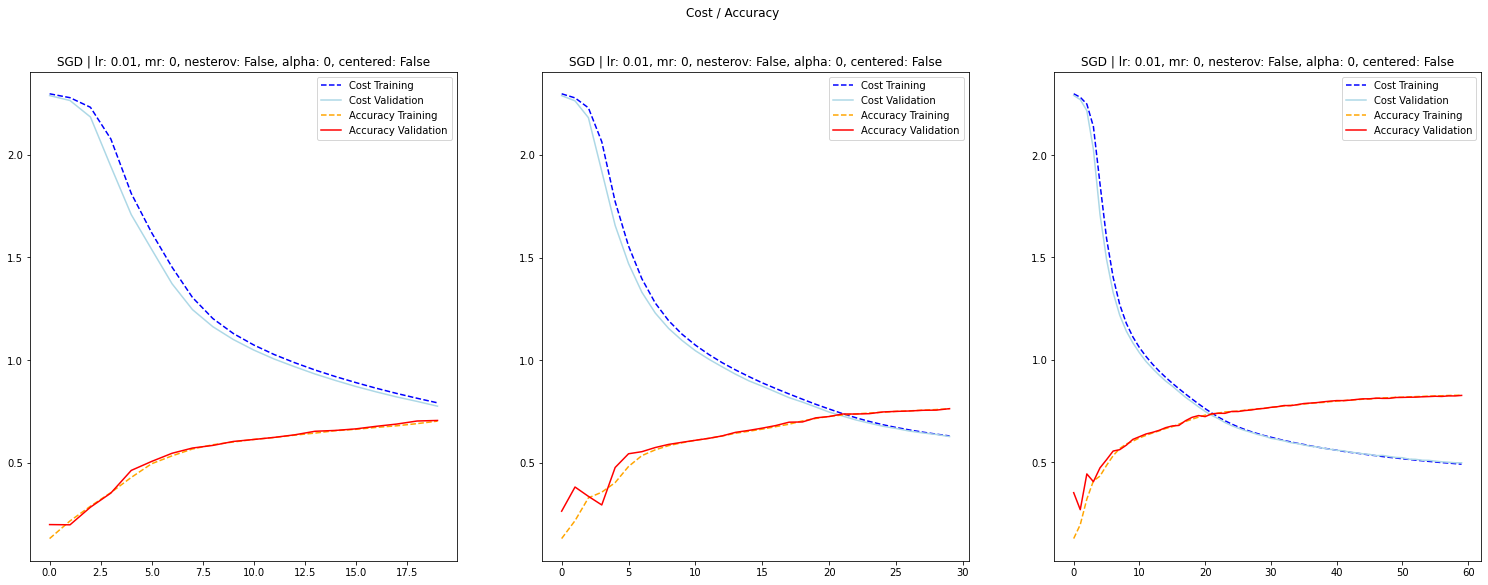

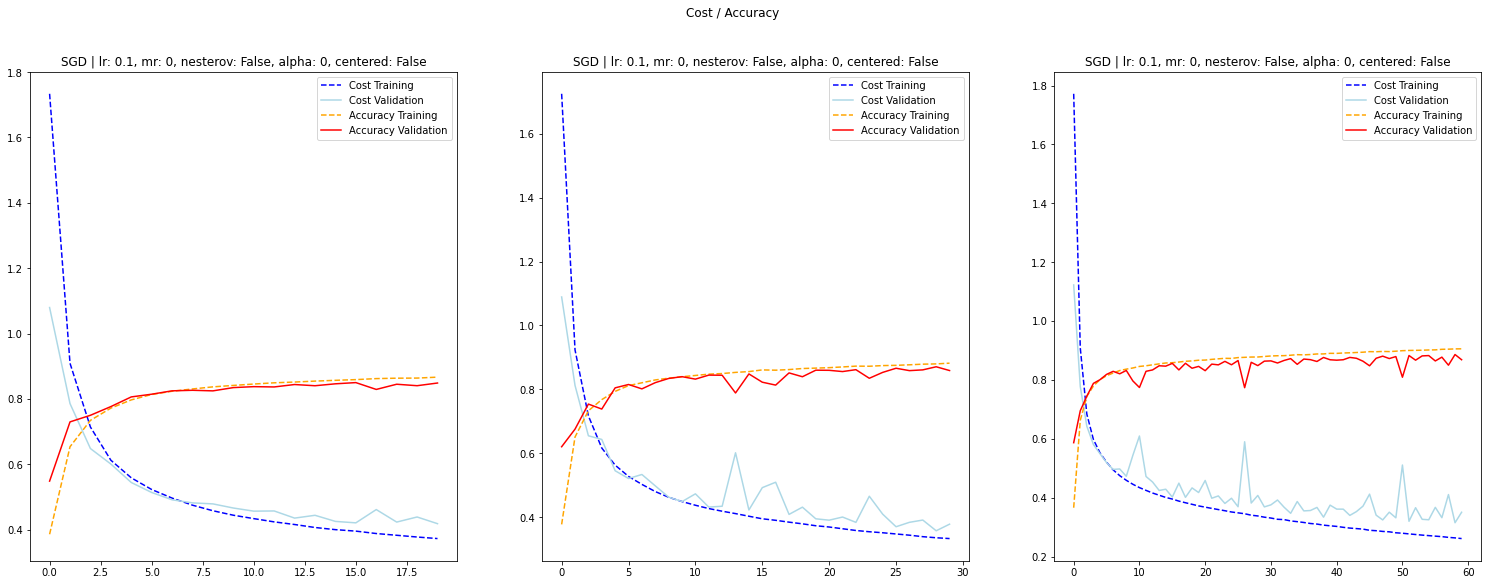

KeyboardInterrupt: 

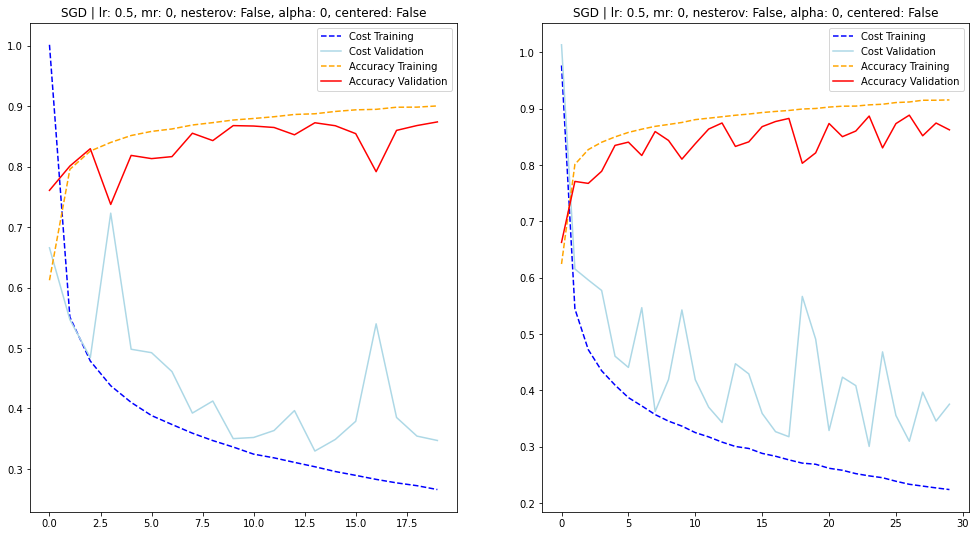

In [33]:
results = []

plot_count = 1
iteration_count = 0
fig = None
ax = None

for config in configs_optimizer_types:
    result = Result(config)

    for nepochs in config.epochs:

        iteration_count += 1

        # reset models and optimizer
        config.reset()

        # initialize new loaders
        training_loader = DataLoader(training_data, batch_size=nbatch, shuffle=True)
        validation_loader = DataLoader(validation_data, batch_size=nbatch, shuffle=True)

        cost_hist, cost_hist_test, acc_hist, acc_hist_test = train_eval(config.model, config.optimizer, nepochs, training_loader, validation_loader, scheduler=None, logs=False)
        result.add_result(model, config.optimizer_params.lr, nepochs, cost_hist, acc_hist, cost_hist_test, acc_hist_test)

        # comment out if you want to disable the single history plots
        fig, plot_count = plot_single_hist(fig, plot_count, cost_hist, cost_hist_test, acc_hist, acc_hist_test, config.optimizer_params)

    results.append(result)

if plot_count != 1:
    fig.suptitle(f"Cost / Accuracy")
    plt.show()

print(f"Number of iterations: {iteration_count}")

In [20]:
result_list = [result.get_max_hist_entry() for result in results]

result_df = pd.DataFrame(result_list, columns=['optimizer', 'optimizer_config', 'lr', 'mr', 'nesterov', 'alpha', 'num_epochs', 'batch_size','cost_valid', 'acc_valid'])

display(result_df)

,optimizer,optimizer_config,lr,mr,nesterov,alpha,num_epochs,batch_size,cost_valid,acc_valid
0,SGD,"lr: 0.01, mr: 0, nesterov: False, alpha: 0",0.01,0.0,False,0.00,60,64,0.82594,0.8212
1,SGD,"lr: 0.1, mr: 0, nesterov: False, alpha: 0",0.10,0.0,False,0.00,60,64,0.90384,0.8814
2,SGD,"lr: 0.5, mr: 0, nesterov: False, alpha: 0",0.50,0.0,False,0.00,60,64,0.92940,0.8939
3,Momentum,"lr: 0.01, mr: 0.9, nesterov: False, alpha: 0",0.01,0.9,False,0.00,60,64,0.90658,0.8847
4,Momentum,"lr: 0.1, mr: 0.9, nesterov: False, alpha: 0",0.10,0.9,False,0.00,60,64,0.95156,0.8982
5,Momentum,"lr: 0.5, mr: 0.9, nesterov: False, alpha: 0",0.50,0.9,False,0.00,20,64,0.86780,0.8681
6,RMSProp,"lr: 0.01, mr: 0, nesterov: False, alpha: 0.99",0.01,0.0,False,0.99,60,64,0.87980,0.8696
7,RMSProp,"lr: 0.1, mr: 0, nesterov: False, alpha: 0.99",0.10,0.0,False,0.99,20,64,0.10192,0.1041
8,RMSProp,"lr: 0.5, mr: 0, nesterov: False, alpha: 0.99",0.50,0.0,False,0.99,20,64,0.10262,0.1041
9,RMSProp,"lr: 0.01, mr: 0, nesterov: False, alpha: 0.95",0.01,0.0,False,0.95,60,64,0.87928,0.8695


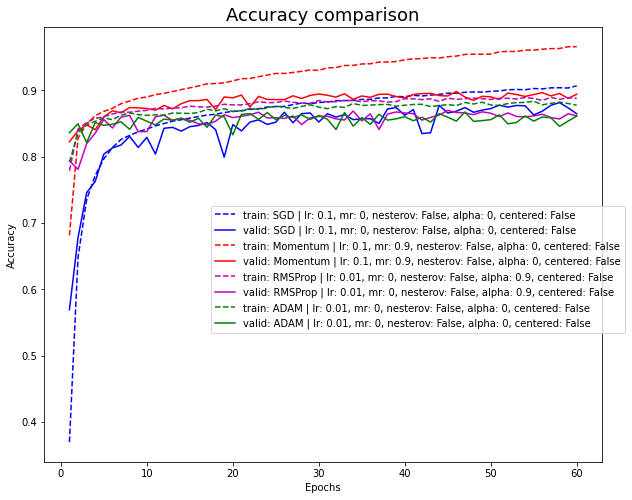

In [22]:
plot_results(results, distinct_optimizer_type=True)

### 2. Train scheduler comparison

In [ ]:
scheduler_results = []

plot_count = 1
iteration_count = 0
fig = None
ax = None

for config in scheduler_configs:
    result = Result(config)
    for nepochs in config.epochs:

        iteration_count += 1

        # reset models and optimizer
        config.reset()

        # initialize new loaders
        training_loader = DataLoader(training_data, batch_size=nbatch, shuffle=True)
        validation_loader = DataLoader(validation_data, batch_size=nbatch, shuffle=True)

        cost_hist, cost_hist_test, acc_hist, acc_hist_test = train_eval(config.model, config.optimizer, nepochs, training_loader, validation_loader, scheduler=config.scheduler, logs=False)
        result.add_result(model, config.optimizer_params.lr, nepochs, cost_hist, acc_hist, cost_hist_test, acc_hist_test)
        fig, plot_count = plot_single_hist(fig, plot_count, cost_hist, cost_hist_test, acc_hist, acc_hist_test, config.optimizer_params)

    scheduler_results.append(result)

if plot_count != 1:
    fig.suptitle(f"Cost / Accuracy")
    plt.show()

print(f"Number of iterations: {iteration_count}")

/Users/manuel/Documents/MSE_Projects/deep_learning/venv/lib/python3.9/site-packages/torch/optim/lr_scheduler.py:129: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "
/Users/manuel/Documents/MSE_Projects/deep_learning/venv/lib/python3.9/site-packages/torch/optim/lr_scheduler.py:129: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate sc

[<__main__.Result object at 0x7fc02cd78d00>, <__main__.Result object at 0x7fc02ce03df0>, <__main__.Result object at 0x7fc02d0469d0>, <__main__.Result object at 0x7fc00f9ceac0>, <__main__.Result object at 0x7fc02d0461f0>, <__main__.Result object at 0x7fc02ce6c880>, <__main__.Result object at 0x7fc02ccf2cd0>, <__main__.Result object at 0x7fc02ccf2d60>, <__main__.Result object at 0x7fc02cda9580>]
True
True
True


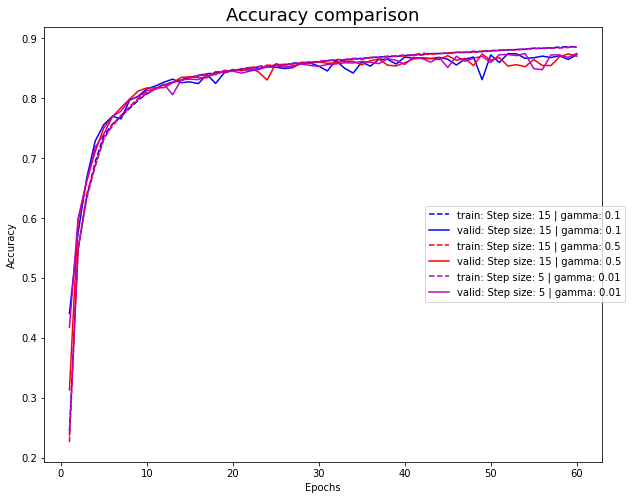

In [176]:
plot_results(scheduler_results, distinct_gamma=True)

### 3. Train Momentum comparison

In [15]:
momentum_results = []

plot_count = 1
iteration_count = 0
fig = None
ax = None

for config in momentum_configs:
    result = Result(config)
    for nepochs in config.epochs:

        iteration_count += 1

        # reset models and optimizer
        config.reset()

        # initialize new loaders
        training_loader = DataLoader(training_data, batch_size=nbatch, shuffle=True)
        validation_loader = DataLoader(validation_data, batch_size=nbatch, shuffle=True)

        cost_hist, cost_hist_test, acc_hist, acc_hist_test = train_eval(config.model, config.optimizer, nepochs, training_loader, validation_loader, scheduler=config.scheduler, logs=False)
        result.add_result(model, config.optimizer_params.lr, nepochs, cost_hist, acc_hist, cost_hist_test, acc_hist_test)

        fig, plot_count = plot_single_hist(fig, plot_count, cost_hist, cost_hist_test, acc_hist, acc_hist_test, config.optimizer_params)

    momentum_results.append(result)

if plot_count != 1:
    fig.suptitle(f"Cost / Accuracy")
    plt.show()

print(f"Number of iterations: {iteration_count}")

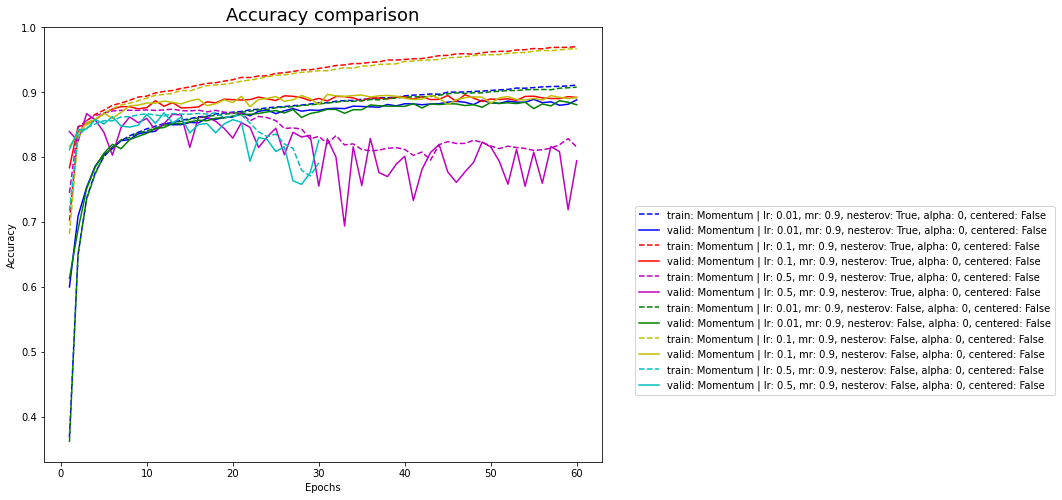

In [16]:
plot_results(momentum_results)

### 4. Train rms prop comparison

In [17]:
rms_props_results = []

plot_count = 1
iteration_count = 0
fig = None
ax = None

for config in rms_props_configs:
    result = Result(config)
    for nepochs in config.epochs:

        iteration_count += 1

        # reset models and optimizer
        config.reset()

        # initialize new loaders
        training_loader = DataLoader(training_data, batch_size=nbatch, shuffle=True)
        validation_loader = DataLoader(validation_data, batch_size=nbatch, shuffle=True)

        cost_hist, cost_hist_test, acc_hist, acc_hist_test = train_eval(config.model, config.optimizer, nepochs, training_loader, validation_loader, scheduler=config.scheduler, logs=False)
        result.add_result(model, config.optimizer_params.lr, nepochs, cost_hist, acc_hist, cost_hist_test, acc_hist_test)

        fig, plot_count = plot_single_hist(fig, plot_count, cost_hist, cost_hist_test, acc_hist, acc_hist_test, config.optimizer_params)

    rms_props_results.append(result)

if plot_count != 1:
    fig.suptitle(f"Cost / Accuracy")
    plt.show()

print(f"Number of iterations: {iteration_count}")

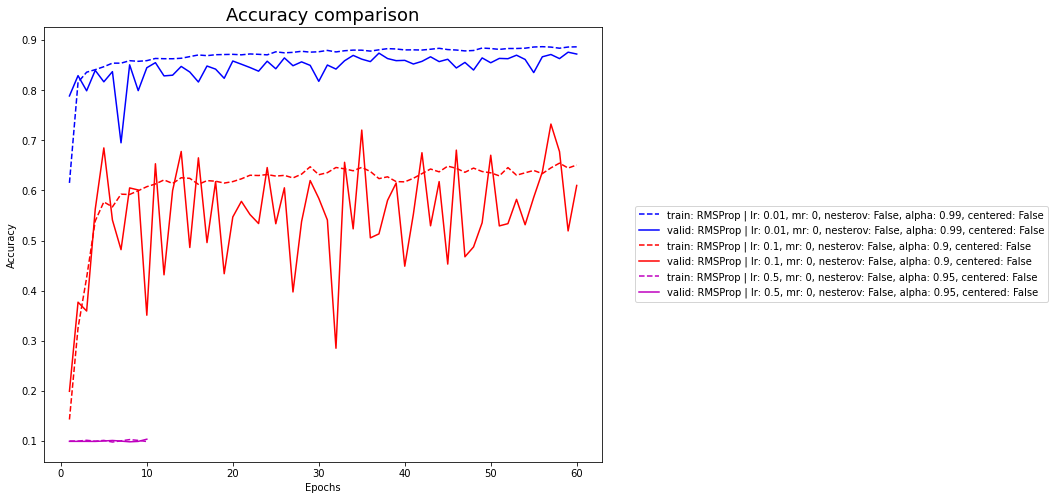

In [20]:
plot_results(rms_props_results, distinct_learning_rate=True)